In [1]:
import os
import re
import time
import pickle
import shutil
import numpy as np
import pandas as pd
from fcsparser import parse
import matplotlib.pyplot as plt
from matplotlib.path import Path
from openpyxl import load_workbook
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def remove_outliers_percentile(df, columns=None, lower_quantile=0.0025, upper_quantile=0.99):
    """
    Удаляет выбросы в датафрейме df, обрезая значения за заданными перцентилями.
    
    Параметры:
    ----------
    df : pd.DataFrame
        Исходный датафрейм.
    columns : list or None
        Список столбцов, по которым ищем выбросы.
        Если None, то берём все числовые столбцы.
    lower_quantile : float
        Нижняя граница (от 0 до 1), по умолчанию 0.0025 (0.25%).
    upper_quantile : float
        Верхняя граница (от 0 до 1), по умолчанию 0.99 (99%).
    
    Возвращает:
    -----------
    pd.DataFrame
        Датафрейм без выбросов.
    """
    
    # Если столбцы не указаны, берём все числовые
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()
    
    # Создадим копию, чтобы не менять исходный датафрейм
    df_clean = df.copy()
    
    for col in columns:
        if col not in df_clean.columns:
            # Если в списке оказался столбец, которого нет в датафрейме
            continue
        
        # Вычислим перцентили
        low_val = df_clean[col].quantile(lower_quantile)
        high_val = df_clean[col].quantile(upper_quantile)
        
        # Фильтруем выбросы
        df_clean = df_clean[(df_clean[col] >= low_val) & (df_clean[col] <= high_val)]
    
    return df_clean

In [3]:
def log_arcsinh_transform_data(data, cofactor_mapping=None):
    """
    Применяет преобразования к датафрейму.
    
    Для столбцов, в названии которых встречается одно из ключевых слов 
    ('CD'), применяется arcsinh-преобразование с заданным ко-фактором.
    Для остальных столбцов выполняется клиппинг (чтобы избежать log(0)) и логарифмирование.
    
    Параметры:
    ----------
    data : pd.DataFrame
        Исходный датафрейм.
    cofactor_mapping : dict, optional
        Словарь, сопоставляющий ключевые слова и их ко-факторы.
        По умолчанию: {'CD': 5}
    
    Возвращает:
    -----------
    pd.DataFrame
        Датафрейм после преобразований.
    """
    if cofactor_mapping is None:
        cofactor_mapping = {'CD': 3, 'Ig': 3}  # хорошие: 5
    
    data_transformed = data.copy()
    
    for col in data_transformed.columns:
        # Если имя столбца содержит одно из ключевых слов,
        # применяем arcsinh-преобразование с соответствующим ко-фактором.
        applied_arcsinh = False
        for key, cofactor in cofactor_mapping.items():
            if key in col:
                data_transformed[col] = np.arcsinh(data_transformed[col] / cofactor)
                applied_arcsinh = True
                break  # Если нашли соответствие, дальнейшие проверки не требуются.
                
        # Если столбец не содержит заданных ключевых слов, применяем стандартное преобразование:
        if not applied_arcsinh:
            # Клиппинг для предотвращения log(0)
            data_transformed[col] = data_transformed[col].clip(lower=1)
            # Логарифмирование по основанию 2
            data_transformed[col] = np.log2(data_transformed[col])
            
    return data_transformed

In [4]:
def make_report(path, blanks, coordinates, clean=True):
    reports_folder = os.path.join(path, "Reports")
    
    # Получаем список CSV-файлов, убирая "Report_of_" из начала
    report_files = [f for f in os.listdir(reports_folder) if f.endswith(".csv")]
    report_names = [f.replace("Report_of_", "").replace(".csv", "") for f in report_files]

    # Загружаем файл координат, не превращая первый столбец в индекс
    coordinates_file = os.path.join(coordinates, "Coordinates.xlsx")
    df_coords = pd.read_excel(coordinates_file, index_col=None)

    for report_name in report_names:
        csv_path = os.path.join(reports_folder, f"Report_of_{report_name}.csv")

        # Ищем подходящий XLSX-файл в папке blanks (начинается с report_name, затем любые символы)
        matching_files = [f for f in os.listdir(blanks) if re.match(fr"^{re.escape(report_name)}.*\.xlsx$", f)]
        if not matching_files:
            continue

        # Берём первый найденный файл (если их несколько)
        xlsx_path = os.path.join(blanks, matching_files[0])
        if not os.path.exists(csv_path):
            continue

        # Загружаем CSV-файл с учетом хедера
        df_report = pd.read_csv(csv_path, header=0)
        
        # Получаем значение для фильтрации из первого столбца CSV
        filter_value = df_report.iloc[0, 0]
        
        # Фильтруем координаты по столбцу "Col0str1_in_report"
        df_filtered = df_coords[df_coords["Col0str1_in_report"] == filter_value]
        if df_filtered.empty:
            continue

        # Открываем XLSX и сохраняем размеры ячеек
        wb = load_workbook(xlsx_path)
        ws = wb.active
        column_widths = {col: ws.column_dimensions[col].width for col in ws.column_dimensions}
        row_heights = {row: ws.row_dimensions[row].height for row in ws.row_dimensions}

        # Перенос данных с проверкой на отсутствие данных в Data_in_report_position
        for _, row in df_filtered.iterrows():
            blank_cell = str(row["Data_in_blank_position"]).strip()
            if pd.isna(row["Data_in_report_position"]):
                ws[blank_cell] = 0
                ws[blank_cell].number_format = '0.00'
            else:
                report_index = int(row["Data_in_report_position"])
                if report_index < len(df_report):
                    # Берем данные из столбца "Mean, %" (предполагается, что это третий столбец)
                    value_to_copy = df_report.iloc[report_index, 2]
                    ws[blank_cell] = value_to_copy
                    ws[blank_cell].number_format = '0.00'
                    
        # Восстанавливаем размеры ячеек
        for col, width in column_widths.items():
            ws.column_dimensions[col].width = width
        for row, height in row_heights.items():
            ws.row_dimensions[row].height = height

        # Сохраняем XLSX
        wb.save(xlsx_path)
        wb.close()

        # Удаляем CSV, если clean=True
        if clean:
            os.remove(csv_path)

In [5]:
def process_test_data(path, tube, pdf=False, fcs_del=True):
    reports_dir = os.path.join(path, "Reports")
    os.makedirs(reports_dir, exist_ok=True)  # Создаём папку Reports в path

    saved_path = os.path.join(path, "Examples", "Saved_UMAP_n_csv")  # Исправленный путь к классификатору

    # Обходим все папки в корневом каталоге, исключая служебные папки
    for folder_name in sorted(os.listdir(path)):
        if folder_name in ["Reports", "Examples"]:
            continue

        folder_path = os.path.join(path, folder_name)
        if not os.path.isdir(folder_path):
            continue

        # Собираем файлы по порядку tube
        ordered_files = []
        for tube_item in tube:
            tube_prefix = tube_item.split('.')[0]
            files_for_prefix = [f for f in os.listdir(folder_path) if tube_prefix in f and f.endswith(".fcs")]
            ordered_files.extend(files_for_prefix)

        if not ordered_files:
            continue  # Пропускаем папку, если нет подходящих .fcs файлов

        pdf_pages = None
        if pdf:
            pdf_path = os.path.join(reports_dir, f"Report of {folder_name}.pdf")
            pdf_pages = PdfPages(pdf_path)
            csv_path = os.path.join(reports_dir, f"Report_of_{folder_name}.csv")

        print(f"\nОбрабатываю папку: {folder_name}")
        for filename in ordered_files:
            file_path = os.path.join(folder_path, filename)

            # Определяем tube_prefix
            tube_prefix = None
            for tube_item in tube:
                prefix = tube_item.split('.')[0]
                if prefix in filename:
                    tube_prefix = prefix
                    break
            if tube_prefix is None:
                print(f"Префикс для файла {filename} не найден.")
                continue

            try:
                meta, data = parse(file_path)
                del meta
                data_no_outliers = remove_outliers_percentile(data)
                data_normalized = log_arcsinh_transform_data(data_no_outliers)
            except Exception as e:
                print(f"Ошибка при обработке {filename}: {e}")
                continue

            classifier_file = None
            if os.path.isdir(saved_path):
                for clf in os.listdir(saved_path):
                    if clf.endswith(".pkl") and tube_prefix in clf:
                        classifier_file = os.path.join(saved_path, clf)
                        break
            if classifier_file is None:
                print(f"Классификатор для {tube_prefix} не найден в {saved_path}.")
                continue

            try:
                with open(classifier_file, "rb") as f:
                    reducer = pickle.load(f)
                umap_result = reducer.transform(data_normalized)
            except Exception as e:
                print(f"Ошибка при применении UMAP {filename}: {e}")
                continue

            umap_df = pd.DataFrame(umap_result, columns=[f'UMAP{i+1}' for i in range(reducer.n_components)])

            polygon_file = os.path.join(saved_path, f"polygons_{tube_prefix}.csv")
            if not os.path.exists(polygon_file):
                print(f"Файл с полигонами {polygon_file} не найден.")
                continue

            try:
                polygons_df = pd.read_csv(polygon_file)
            except Exception as e:
                print(f"Ошибка при загрузке полигонов {polygon_file}: {e}")
                continue

            # ---- Визуализация UMAP ----
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.scatter(umap_df["UMAP1"], umap_df["UMAP2"], s=5, alpha=0.5, label="Data")

            umap_df_result = umap_df.copy()
            polygon_groups = {}
            added_legend_items = set()

            for (name, n) in polygons_df[["name", "n"]].drop_duplicates().itertuples(index=False):
                poly_data = polygons_df[(polygons_df["name"] == name) & (polygons_df["n"] == n)]
                polygon = np.array(list(zip(poly_data["x"], poly_data["y"])))
                poly_color = poly_data["color"].iloc[0]
                legend_key = (name, poly_color)
                poly_patch = Polygon(polygon, edgecolor=poly_color, facecolor="none", lw=2)
                ax.add_patch(poly_patch)
                if legend_key not in added_legend_items:
                    ax.plot([], [], color=poly_color, label=name)
                    added_legend_items.add(legend_key)
                path_obj = Path(polygon)
                inside = path_obj.contains_points(umap_df[["UMAP1", "UMAP2"]].values).astype(np.int32)
                if name in polygon_groups:
                    polygon_groups[name] |= inside
                else:
                    polygon_groups[name] = inside

            for name, inside_mask in polygon_groups.items():
                umap_df_result[name] = inside_mask

            ax.legend()
            plt.xlabel("UMAP1")
            plt.ylabel("UMAP2")
            plt.title(f"Тестовые данные: {filename}")

            # ---- Подготовка статистики ----
            stats = umap_df_result.describe().T.iloc[2:, :2]
            if "Trash" in umap_df_result.columns:
                total_cells = len(umap_df_result)
                trash_count = (umap_df_result["Trash"] == 1).sum()
                granulocytes_count = (umap_df_result["Granulocytes"] == 1).sum() if "Granulocytes" in umap_df_result.columns else 0
                mononuclears = total_cells - trash_count - granulocytes_count
                stats.loc["Mononuclears", ["count", "mean"]] = [mononuclears, mononuclears / total_cells * 100]
                if "Granulocytes" in umap_df_result.columns:
                    stats.loc["Granulocytes", ["count", "mean"]] = [granulocytes_count, granulocytes_count / (total_cells - trash_count) * 100]
                for pop in polygon_groups.keys():
                    if pop in umap_df_result.columns and pop not in ["Trash", "Granulocytes"]:
                        count = umap_df_result[pop].sum()
                        stats.loc[pop, ["count", "mean"]] = [count, count / mononuclears * 100]

            stats.columns = ['Абс. количество', 'Содержание, %']
            stats['Абс. количество'] = stats['Абс. количество'].astype(np.int32)
            stats['Содержание, %'] = stats['Содержание, %'].astype(np.float32).round(4)
            stats = stats.drop("Trash", errors="ignore")

            print(f"\nСтатистика для пробирки {filename} (пациент: {folder_name}):")
            plt.show()
            display(stats)
            plt.close(fig)

            if pdf and pdf_pages:
                pdf_pages.savefig(fig)
                plt.close(fig)
                fig_table, ax_table = plt.subplots(figsize=(8, 4))
                ax_table.axis('tight')
                ax_table.axis('off')
                table_data = stats.reset_index().values.tolist()
                table_data.insert(0, ["Группа", "Абс. количество", "Содержание, %"])
                ax_table.table(cellText=table_data, loc="center", cellLoc="center")
                plt.title(f"Статистика для образца {folder_name}.")
                pdf_pages.savefig(fig_table)
                plt.close(fig_table)
            if pdf:
                stats.to_csv(csv_path, mode='a', header=not os.path.exists(csv_path))
                print(f"Отчёт сохранён в {csv_path}")

        if pdf and pdf_pages:
            pdf_pages.close()
            print(f"Отчёт сохранён в {pdf_path}")

        if fcs_del:
            shutil.rmtree(folder_path)
            print(f"Удалена папка: {folder_path}")

In [6]:
# path = r"C:\Users\vsemis\files\Flow_cyt_robot" # внимание комп
path = r"D:\NovoExpress Data"  # очередной комп
tube = [r"10_56_45_19_138_38.fcs", r"λ_κ_45_117_138_38.fcs", r"xx_79a_45_Ki67_3_xx.fcs"]


Обрабатываю папку: Попович Г.Н
Sun Mar  9 22:10:15 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/30 [00:00]

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs

Статистика для пробирки 10_56_45_19_138_38.fcs (пациент: Попович Г.Н):


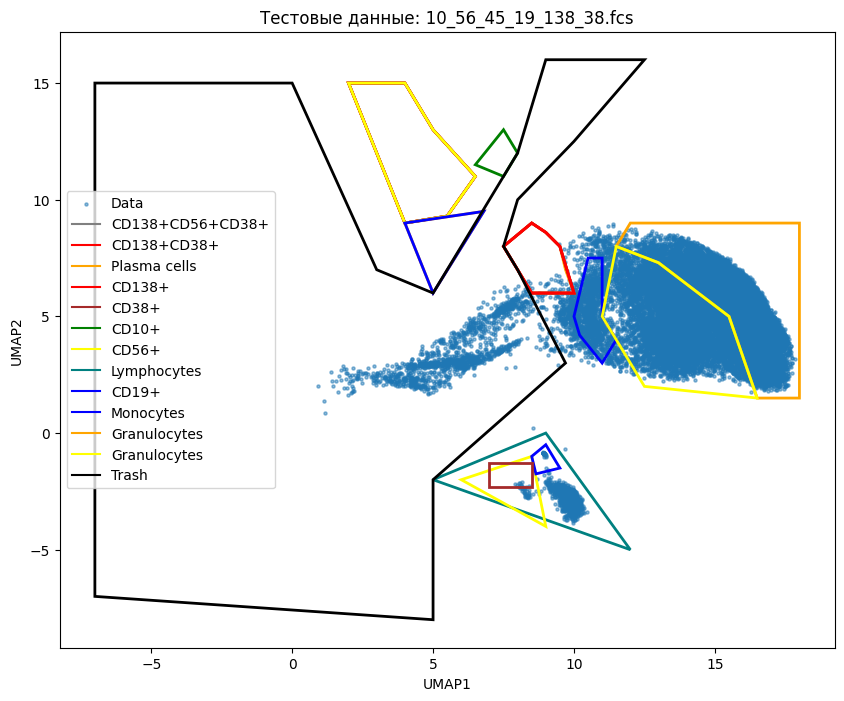

,Абс. количество,"Содержание, %"
CD138+CD56+CD38+,0,0.000000
CD138+CD38+,31,1.127300
Plasma cells,30,1.090900
CD138+,31,1.127300
CD38+,41,1.490900
CD10+,0,0.000000
CD56+,41,1.490900
Lymphocytes,760,27.636400
CD19+,46,1.672700
Monocytes,1066,38.763599


Отчёт сохранён в D:\NovoExpress Data\Reports\Report_of_Попович Г.Н.csv
Sun Mar  9 22:11:18 2025 Building and compiling search function


C:\Users\vsevo\flowcytlibs\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
%%time
process_test_data(path, tube, pdf=True, fcs_del=True)

In [ ]:
make_report(path,  # Корневая папка, в которой лежит папка Reports с новыми отчётами.
            blanks=r'C:\Users\vsevo\Downloads',  # Папка с заключениями 
            coordinates=r'D:\NovoExpress Data\Examples\Saved_UMAP_n_csv',  # Координаты для связи репорта и бланка заключения
            clean=True)  # Если True (по умолчанию), отчётные файлы будут удалены